In [1]:
import sys, importlib
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import copy
import time
from collections import OrderedDict

sys.path.append("../")
from proj_mod import training, data_processing, visualization
importlib.reload(training);
importlib.reload(data_processing);
importlib.reload(visualization);

device=(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Using device {device}")

Using device cuda


# Functions to optimize hyperparameters

In [2]:
import optuna
import torch.optim as optim

def train_one_epoch(model, dataloader, optimizer, device, eps=0):
    model.train()
    loss_fn = training.RMSPELoss(eps=eps) 
    total_data_count=len(dataloader.dataset)
    sum_of_squares=0.0
    for batch in dataloader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            sum_of_squares+=torch.sum(torch.square((pred-y)/(y+eps)))
    with torch.no_grad():
        rmspe=torch.sqrt(sum_of_squares/total_data_count)
    return rmspe.item()

def validate(model, dataloader, device, eps=0):
    model.eval()
    sum_of_squares = 0.0
    total_data_count=len(dataloader.dataset)
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            pred = model(x)
            sum_of_squares += torch.sum(torch.square((pred - y) / (y + eps)))
        rmspe = torch.sqrt(sum_of_squares / total_data_count)
    return rmspe.item()

def objective(trial, define_model): 

    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)

    model = define_model(trial).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode="min",factor=0.5,patience=5,min_lr=1e-7)

    eps = 1e-5
    best_val_loss = float('inf')

    patience = 3
    patience_counter = 0
    max_epochs = 10

    
    for epoch in range(max_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device, eps)
        val_loss = validate(model, test_loader, device, eps)

        scheduler.step(val_loss)
        
        trial.report(val_loss, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        if val_loss < best_val_loss - 1e-4:  # added minimum delta threshold
            best_val_loss = val_loss
            patience_counter = 0          # reset counter on improvement
        else:
            patience_counter += 1         # increment if no improvement

            # Early stopping
            if patience_counter >= patience:
                break  
    
    return best_val_loss

/home/machine2/.deeplearningcourse/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Usage examples

## Needed by both models

### Data and splitting

In [2]:
list_time=np.load("../processed_data/recovered_time_id_order.npy")
df_RV_ts=pd.read_parquet("../processed_data/book_RV_ts_60_si.parquet")

df_target=pd.read_csv("../raw_data/kaggle_ORVP/train.csv")
df_target["row_id"]=df_target["stock_id"].astype(int).astype(str)+"-"+df_target["time_id"].astype(int).astype(str)

time_split_list=data_processing.time_cross_val_split(list_time=list_time,n_split=1,percent_val_size=10,list_output=True)
train_time_id,test_time_id=time_split_list[0][0],time_split_list[0][1]

In fold 0 :

Train set end at 8117 .

Test set start at 15516 end at 10890 .



### Modules

In [3]:
ts_emb_dim=32
n_diff=2
ts_dim=n_diff+1

pos_embedder=training.pos_emb_cross_attn(length=60,ts_dim=ts_dim,emb_dim=ts_emb_dim,dropout=0.2,num_heads=4,keep_mag=True).to(device=device)

ts_encoder_ff_layer=[
    nn.Linear(in_features=ts_emb_dim,out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64,out_features=ts_emb_dim)
]

ts_decoder_ff_layer=[
    nn.Linear(in_features=ts_emb_dim,out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64,out_features=ts_emb_dim)
]

output_ff=nn.Sequential(
    nn.Linear(in_features=ts_emb_dim,out_features=1)
).to(device=device)

## Encoder-decoder model without id

### Dataset creation

In [4]:
train_dataset=training.RVdataset(time_id_list=train_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_target=df_target)
test_dataset=training.RVdataset(time_id_list=test_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_target=df_target)

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

/home/machine2/Desktop/Realized_Volatility_Prediction_-erdos_deeplearning-/NNetwork/../proj_mod/training.py:396: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tab_copy["sub_int_num"]=np.nan
/home/machine2/Desktop/Realized_Volatility_Prediction_-erdos_deeplearning-/NNetwork/../proj_mod/training.py:396: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tab_copy["sub_int_num"]=np.nan


### Model definition and optimization of hyperparameters

In [6]:
def define_model_encdec(trial):
    encoder_layers = trial.suggest_int("encoder_layer_num", 2, 6)
    decoder_layers = trial.suggest_int("decoder_layer_num", 2, 6)
    dropout = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)   

    return training.encoder_decoder_teacherforcing(
        pos_emb_model=pos_embedder,
        output_feedforward=output_ff,
        encoder_dropout=dropout,
        decoder_dropout=dropout,
        encoder_feedforward_list=ts_encoder_ff_layer,
        decoder_feedforward_list=ts_decoder_ff_layer,
        n_diff=n_diff,
        encoder_layer_num=encoder_layers,
        decoder_layer_num=decoder_layers,
        input_scaler=10000,
        ts_emb_dim=ts_emb_dim,
        encoder_num_heads=4,
        decoder_num_heads=4,
        encoder_keep_mag=True,
        decoder_keep_mag=True,
        return_sum=True
    )

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, define_model_encdec), n_trials=20)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-08-05 11:36:25,325] A new study created in memory with name: no-name-bc692c32-10ab-4582-aa9a-cc86bb084c2a
[I 2025-08-05 11:41:09,291] Trial 0 finished with value: 0.2353174388408661 and parameters: {'lr': 1.2367443736920106e-05, 'encoder_layer_num': 3, 'decoder_layer_num': 4, 'dropout': 0.0}. Best is trial 0 with value: 0.2353174388408661.
[I 2025-08-05 11:44:15,487] Trial 1 finished with value: 0.23198272287845612 and parameters: {'lr': 0.004276910308898425, 'encoder_layer_num': 4, 'decoder_layer_num': 5, 'dropout': 0.4}. Best is trial 1 with value: 0.23198272287845612.
[I 2025-08-05 11:48:36,632] Trial 2 finished with value: 0.22980597615242004 and parameters: {'lr': 6.770198040031588e-05, 'encoder_layer_num': 5, 'decoder_layer_num': 2, 'dropout': 0.2}. Best is trial 2 with value: 0.22980597615242004.
[I 2025-08-05 11:50:42,074] Trial 3 finished with value: 0.2298048883676529 and parameters: {'lr': 0.00033859534123581957, 'encoder_layer_num': 2, 'decoder_layer_num': 2, 'dropo

Best trial:
  Value: 0.2290985882282257
    lr: 0.00011506673504111632
    encoder_layer_num: 5
    decoder_layer_num: 6
    dropout: 0.4


In [7]:
# best_encoder_layer_num = trial.params.get('encoder_layer_num')
# best_decoder_layer_num = trial.params.get('decoder_layer_num')
# best_dropout = trial.params.get('dropout')
# best_lr = trial.params.get('lr')
import torch.optim as optim

best_lr = 0.00011506673504111632
best_encoder_layer_num = 5
best_decoder_layer_num = 6
best_dropout = 0.4

trans_encoder_decoder_tf_model=training.encoder_decoder_teacherforcing(
    pos_emb_model=pos_embedder,
    output_feedforward=output_ff,
    encoder_dropout=best_dropout,
    decoder_dropout=best_dropout,
    encoder_feedforward_list=ts_encoder_ff_layer,
    decoder_feedforward_list=ts_decoder_ff_layer,
    n_diff=n_diff,
    encoder_layer_num=best_encoder_layer_num,
    decoder_layer_num=best_encoder_layer_num,
    input_scaler=10000,
    ts_emb_dim=ts_emb_dim,
    encoder_num_heads=4,
    decoder_num_heads=4,
    encoder_keep_mag=True,
    decoder_keep_mag=True,
    return_sum=True
).to(device=device)

optimizer = optim.AdamW(trans_encoder_decoder_tf_model.parameters(), lr=best_lr)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.5, patience=5, min_lr=1e-7)

# Loss tracking
train_loss = []
val_loss = []

en4de4_weight_dict=training.reg_training_loop_rmspe(
    optimizer=optimizer,
    model=trans_encoder_decoder_tf_model,
    train_loader=train_loader,
    val_loader=test_loader,
    ot_steps=20,
    report_interval=5,
    n_epochs=200,
    list_train_loss=train_loss,
    list_val_loss=val_loss,
    device=device,
    eps=1e-8,
    scheduler=scheduler)

A new best validation loss at epoch  1  with validation loss of  tensor(0.2381, device='cuda:0') .
At  43.56676435470581  epoch  1 has training loss  tensor(0.3007, device='cuda:0')  and validation loss  tensor(0.2381, device='cuda:0') .

A new best validation loss at epoch  2  with validation loss of  tensor(0.2374, device='cuda:0') .
A new best validation loss at epoch  4  with validation loss of  tensor(0.2333, device='cuda:0') .
At  225.37839102745056  epoch  5 has training loss  tensor(0.2496, device='cuda:0')  and validation loss  tensor(0.2353, device='cuda:0') .

A new best validation loss at epoch  7  with validation loss of  tensor(0.2319, device='cuda:0') .
A new best validation loss at epoch  10  with validation loss of  tensor(0.2314, device='cuda:0') .
At  452.23326683044434  epoch  10 has training loss  tensor(0.2483, device='cuda:0')  and validation loss  tensor(0.2314, device='cuda:0') .

A new best validation loss at epoch  11  with validation loss of  tensor(0.2312, 

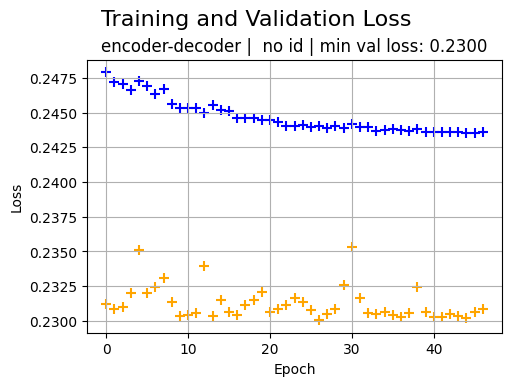

In [8]:
from proj_mod import visualization


vis_dict={("encoder-decoder","no id"):{"train_loss": train_loss[10:],"val_loss": val_loss[10:]}}
visualization.training_plots(vis_dict, fig_width=5)

## Encoder-decoder model with id

### Data and dataset creation

In [7]:
RV_tab=pd.read_csv("../processed_data/RV_by_row_id.csv")
RV_tab["stock_id"]=RV_tab["row_id"].apply(lambda x: x.split("-")[0])
RV_tab["time_id"]=RV_tab["row_id"].apply(lambda x: x.split("-")[1])

# Creates tabular data, most specifically 'emb_id'
unique_ids = sorted(RV_tab['stock_id'].unique())
id_to_emb = {stock_id: i for i, stock_id in enumerate(unique_ids)}
RV_tab['emb_id'] = RV_tab['stock_id'].map(id_to_emb)

train_dataset=training.RVdataset(time_id_list=train_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_tab_feat=RV_tab,df_target=df_target)
test_dataset=training.RVdataset(time_id_list=test_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_tab_feat=RV_tab,df_target=df_target)

ts_place, id_place=train_dataset.featureplace["sub_int_RV"], train_dataset.featureplace["emb_id"]

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

### Model definition and optimization of hyperparameters

In [8]:

def define_model_encdec_id(trial):
    encoder_layers = trial.suggest_int("encoder_layer_num", 2, 6)
    decoder_layers = trial.suggest_int("decoder_layer_num", 2, 6)
    dropout = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)   

    base_model =training.encoder_decoder_teacherforcing(
        pos_emb_model=pos_embedder,
        output_feedforward=output_ff,
        encoder_dropout=dropout,
        decoder_dropout=dropout,
        encoder_feedforward_list=ts_encoder_ff_layer,
        decoder_feedforward_list=ts_decoder_ff_layer,
        n_diff=n_diff,
        encoder_layer_num=encoder_layers,
        decoder_layer_num=decoder_layers, 
        input_scaler=10000,
        ts_emb_dim=ts_emb_dim,
        encoder_num_heads=4,
        decoder_num_heads=4,
        encoder_keep_mag=True,
        decoder_keep_mag=True,
        return_sum=True
    )

    id_emb_dim=8
    id_hidden_dict=OrderedDict([("linear1", nn.Linear(in_features=id_emb_dim, out_features=32),),
                                ("tanh1", nn.Tanh()),
                                ("linear2", nn.Linear(in_features=32, out_features=16)),
                                ("tanh2", nn.Tanh()),
                                ("linear3", nn.Linear(in_features=16, out_features=8)),
                                ("tanh3", nn.Tanh()),
                                ("linear4", nn.Linear(in_features=8,out_features=1))])
    id_hidden_layers=nn.Sequential(id_hidden_dict).to(device=device)

    return training.id_learned_embedding_adj_rnn_mtpl(ts_place=ts_place,
                                             id_place=id_place, 
                                             rnn_model=base_model,
                                             id_hidden_model=id_hidden_layers,
                                             id_input_num=112,
                                             emb_dim=id_emb_dim)

study2 = optuna.create_study(direction="minimize")
study2.optimize(lambda trial: objective(trial, define_model_encdec_id), n_trials=20)

print("Best trial:")
trial = study2.best_trial
print(f"  Value: {trial.value}")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-08-05 12:40:02,324] A new study created in memory with name: no-name-74a62b8d-d5af-487c-921e-7c55b16d7c3a
[I 2025-08-05 12:46:33,036] Trial 0 finished with value: 0.9882119297981262 and parameters: {'lr': 8.252949955028464e-05, 'encoder_layer_num': 5, 'decoder_layer_num': 4, 'dropout': 0.4}. Best is trial 0 with value: 0.9882119297981262.
[I 2025-08-05 12:53:34,941] Trial 1 finished with value: 0.5642998218536377 and parameters: {'lr': 0.008981699831132471, 'encoder_layer_num': 6, 'decoder_layer_num': 4, 'dropout': 0.1}. Best is trial 1 with value: 0.5642998218536377.
[I 2025-08-05 13:01:00,244] Trial 2 finished with value: 0.2239001989364624 and parameters: {'lr': 0.0012781920969917263, 'encoder_layer_num': 3, 'decoder_layer_num': 6, 'dropout': 0.1}. Best is trial 2 with value: 0.2239001989364624.
[I 2025-08-05 13:06:08,455] Trial 3 finished with value: 0.2566831111907959 and parameters: {'lr': 8.432537854406163e-05, 'encoder_layer_num': 2, 'decoder_layer_num': 4, 'dropout': 0

Best trial:
  Value: 0.2228439897298813
    lr: 0.0006252038799750985
    encoder_layer_num: 2
    decoder_layer_num: 6
    dropout: 0.30000000000000004
